# Extended Trapping SINDy
By Alan Kaptanoglu

A very common issue is that models identified by system identification methods typically have no guarantees that the models are numerically or physically stable. This can be addressed with heuristic, data-driven, or analytic closure models, but we have recently directly promoted globally stable models into the system identification itself (see the Example 8 Jupyter notebook). This is really nice but there are three potential caveats, (1) the regression is nonconvex and there a number of hyperparameters, so this method can be difficult to learn, and (2) in order to promote global stability, one needs an analytic result from stability theory, and the one we use applies only for quadratically nonlinear dynamics (typically fluid and plasma flows) with energy-preserving, quadratic, nonlinearities. Moreover, we have now (3) additionally shown that generic quadratically nonlinear models will always be globally *unbounded*, so for these situations we can also promote local Lyapunov stability of the origin using some variations of the original Trapping SINDy algorithm. That is the goal of this notebook -- to illustrate how various forms of global and local stability can be promoted explicitly in the SINDy method to obtain stable data-driven models.

For the following, we will consider dynamical models of the form
$$\dot{x}_i = L_{ij}x_j + Q_{ijk}x_ix_jx_k.$$
For global stability promotion, we will require skew-symmetry in the quadratic coefficients
$$ Q_{ijk} + Q_{jik} + Q_{kij} = 0.$$
This equation will be implemented as a hard constraint in the optimization. However, for dynamical models that do not satisfy this condition, we can still promote locally stable models that are stable even at fairly large distances of the origin. The following examples show different ways to relax this hard constraint.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import scipy.io as sio
from pysindy.utils import lorenz

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Define some setup and plotting functions
# Build the skew-symmetric nonlinearity constraints
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        # constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 3.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1 / 2.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1 / 2.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1 / 2.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix


# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
def check_stability(r, Xi, mod_matrix, sindy_opt, mean_val):
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PM_tensor = sindy_opt.PM_
    PQ_tensor = sindy_opt.PQ_
    # mPQ = -np.tensordot(
    #             sindy_opt.PQ_,
    #             opt_m, axes=([2], [0])
    # ) - np.tensordot(
    #             np.transpose(sindy_opt.PQ_, [0, 2, 1, 3, 4]),
    #             opt_m, axes=([1], [0]),
    # )
    # mPQ = (mPQ + np.transpose(mPQ, [1, 0, 2, 3])) / 2.0
    mPM = np.tensordot(PM_tensor, opt_m, axes=([2], [0]))
    P_tensor = PL_tensor + mPM
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    As = mod_matrix @ As
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    d = mod_matrix @ d
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    Reff = Rm / mean_val
    print('Estimate of trapping region size, Rm = ', Rm)
    print('Normalized trapping region size, Reff = ', Reff)


# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 
             'r', label='true x')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 
             'k', label='pred x')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.legend(fontsize=14)
    plt.show()


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(16, 8))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r', 
                 label=r'true $\dot{x}_' + str(i) + '$')
        plt.plot(t, xdot_test_pred[:, i], 'k--', 
                 label=r'pred $\dot{x}_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r', label=r'true $x_' + str(i) + '$')
        plt.plot(t, x_test_pred[:, i], 'k--', label=r'pred $x_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        
    plt.show()
    
    
# Plot errors between m_{k+1} and m_k and similarly for the model coefficients
def make_progress_plots(r, sindy_opt):
    W = np.asarray(sindy_opt.history_)
    M = np.asarray(sindy_opt.m_history_)
    dW = np.zeros(W.shape[0])
    dM = np.zeros(M.shape[0])
    for i in range(1,W.shape[0]):
        dW[i] = np.sum((W[i, :, :] - W[i - 1, :, :]) ** 2)
        dM[i] = np.sum((M[i, :] - M[i - 1, :]) ** 2)
    plt.figure()
    plt.semilogy(dW, label=r'Coefficient progress, $\|\xi_{k+1} - \xi_k\|_2^2$')
    plt.semilogy(dM, label=r'Vector m progress, $\|m_{k+1} - m_k\|_2^2$')
    plt.xlabel('Algorithm iterations', fontsize=16)
    plt.ylabel('Errors', fontsize=16)
    plt.legend(fontsize=14)
    PWeigs = np.asarray(sindy_opt.PWeigs_history_)
    plt.figure()
    for j in range(r):
        if np.all(PWeigs[:, j] > 0.0):
            plt.semilogy(PWeigs[:, j], 
                         label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        else:
            plt.plot(PWeigs[:, j], 
                     label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        plt.xlabel('Algorithm iterations', fontsize=16)
        plt.legend(fontsize=12)
        plt.ylabel(r'Eigenvalues of $P\xi$', fontsize=16)

# Initialize quadratic SINDy library, with custom ordering 
# to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, 
                                 function_names=library_function_names)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-15
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-10

# Lorenz model
The Lorenz system originates from a simple fluid model of atmospheric dynamics from Lorenz et al. (1963).
This system is likely the most famous example of chaotic, nonlinear behavior despite the somewhat innocuous system of equations,

$$
\begin{align}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} &= \begin{bmatrix}
    -\sigma & \sigma & 0 \\
    \rho & -1 & 0 \\
    0 & 0 & -\beta
    \end{bmatrix}
    \begin{bmatrix}
    x \\
    y \\
    z
    \end{bmatrix}
    +
    \begin{bmatrix}
    0 \\
    -xz \\
    xy
    \end{bmatrix}, \qquad
    \mathbf{A}^S = \begin{bmatrix}
    -\sigma & \frac{1}{2}(\rho+\sigma - m_3) & \frac{1}{2}m_2 \\
    \frac{1}{2}(\rho+\sigma - m_3) & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}.
\end{align}
$$

For Lorenz's choice of parameters, $\sigma = 10$, $\rho = 28$, $\beta  = 8/3$, this system is known to exhibit a stable attractor. For $\mathbf{m} = [0,m_2,\rho+\sigma]$ ($m_1$ does not contribute to $\mathbf{A}^S$ so we set it to zero),

$$
\begin{align}
    \mathbf{A}^S &= \begin{bmatrix}
    -\sigma & 0 & \frac{1}{2}m_2 \\
    0 & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}, \qquad
    \lambda_1 = -1, \qquad \lambda_{\pm} = -\frac{1}{2}\left[\beta+\sigma \mp \sqrt{m_2^2 + (\beta-\sigma)^2}\right],
\end{align}
$$

so that if $\lambda_{\pm} < 0$, then $-2\sqrt{\sigma\beta} < m_2 < 2\sqrt{\sigma\beta}$. 
Our algorithm can successfully identify the optimal $\mathbf{m}$, and can be used to identify the inequality bounds on $m_2$ for stability. 

### Check global stability of the Lorenz model
The skew-symmetric models below are globally stable *if and only if* there exists a vector $\mathbf{m}$ such that following matrix is negative definite:
$$A^S_{ij} = L^S_{ij} + (Q_{ijk} + Q_{jik})m_k.$$
Note that if the quadratic terms are skew-symmetric this is equal to
$$A^S_{ij} = L^S_{ij} - Q_{kij}m_k.$$
A negative definite $\mathbf{A}^S$ turns out to also be necessary for the non-skew-symmetric models, but in this case is not sufficient for global boundedness.

A good algorithm for a nonlinear search for a good $\mathbf{m}$ is simulated annealing, and a simple interface is provided by scipy. We show below that the models that are exactly skew-symmetric are globally stable, and the models that (weakly) break this constraint are not. This is true whether or not we consider the energy, enstrophy, or some other positive definite function!

In [12]:
# define parameters
r = 3
N = int((r ** 2 + 3 * r) / 2.0)
# make training and testing data
dt = 0.01
T = 100
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T

# define hyperparameters
threshold = 0
max_iter = 20000
eta = 1.0e-1

# See below code if using threshold !=0
# if threshold != 0:
#     max_iter = 1000
#     eta = 1.0e-1
constraint_zeros, constraint_matrix = make_constraints(r)

alpha_m = 2e-1 * eta  # default is 1e-2 * eta so this speeds up the code here
accel = True  # use acceleration for the update of (m, A), sometimes is faster

# run trapping SINDy
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                           accel=accel, max_iter=max_iter, gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           verbose=True
                           )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t, quiet=True)
model.print()

Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)



 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 6.372e+02 ... 1.273e+03 ... 0.00e+00 ... 4.93e-21 ... 3.60e-48 ... 1.91e+03
 2000 ... 2.893e+03 ... 1.793e-02 ... 0.00e+00 ... 4.75e-21 ... 1.11e-48 ... 2.89e+03
 4000 ... 2.978e+03 ... 5.160e-03 ... 0.00e+00 ... 4.75e-21 ... 5.81e-48 ... 2.98e+03
 6000 ... 3.017e+03 ... 2.753e-03 ... 0.00e+00 ... 4.75e-21 ... 1.65e-48 ... 3.02e+03
 8000 ... 3.041e+03 ... 1.868e-03 ... 0.00e+00 ... 4.75e-21 ... 4.17e-48 ... 3.04e+03
10000 ... 3.057e+03 ... 1.438e-03 ... 0.00e+00 ... 4.74e-21 ... 3.90e-48 ... 3.06e+03
12000 ... 3.070e+03 ... 1.195e-03 ... 0.00e+00 ... 4.74e-21 ... 4.05e-49 ... 3.07e+03
14000 ... 3.079e+03 ... 1.044e-03 ... 0.00e+00 ... 4.74e-21 ... 4.70e-48 ... 3.08e+03
16000 ... 3.087e+03 ... 9.433e-04 ... 0.00e+00 ... 4.74e-21 ... 2.02e-48 ... 3.09e+03
18000 ... 3.094e+03 ... 8.738e-04 ... 0.00e+00 ... 4.74e-21 ... 7.38e-48 ... 3.09e+03
(x0)' = -9.913 x0 + 9.956 x1 + 0.003 x2 + 0.002 x0x

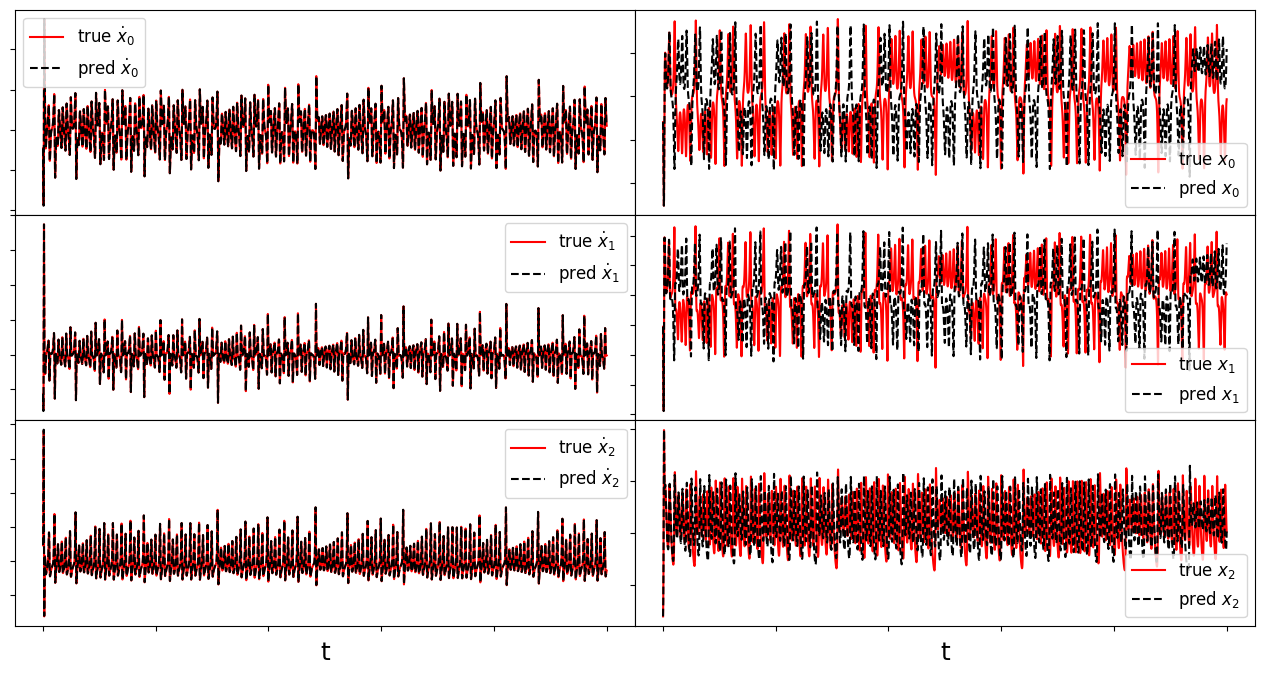

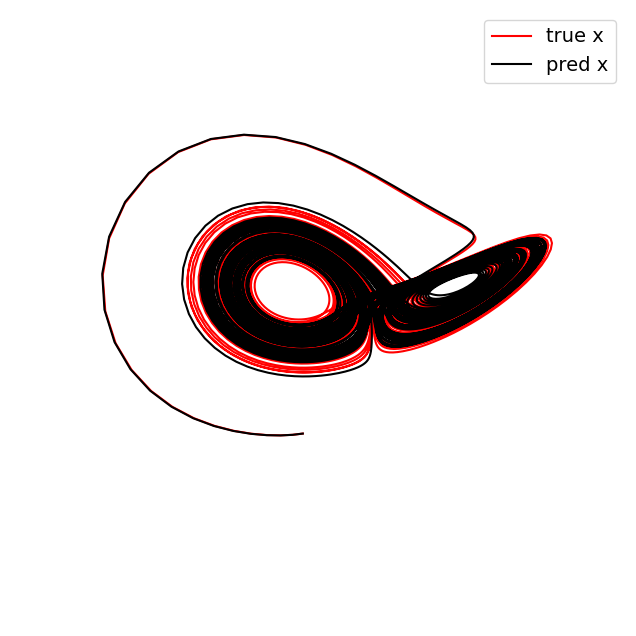

optimal m:  [-1.2431208  -0.16369834 38.05125247]
As eigvals:  [-9.97420799 -2.63191135 -0.9871614 ]
Estimate of trapping region size, Rm =  102.67118782087918
Normalized trapping region size, Reff =  4.3682735342394965
Frobenius error =  0.762028386524666
Frobenius coefficient error =  0.03452382110247034
Time-averaged derivative error =  0.00010230465852438372


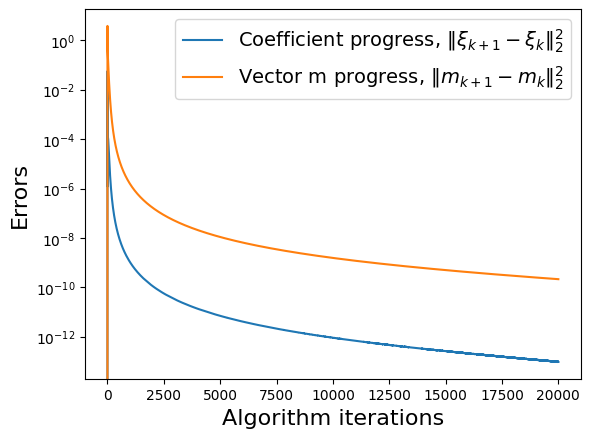

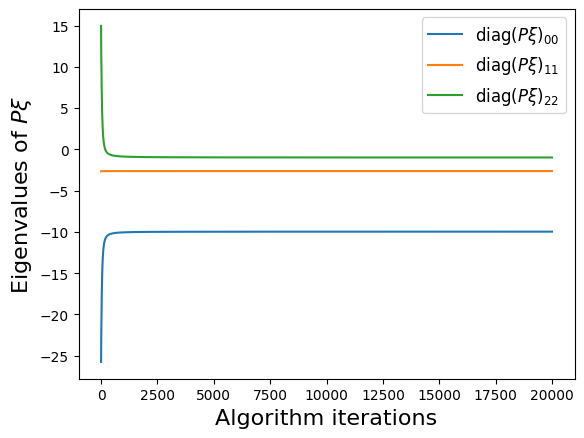

In [70]:
# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')
make_3d_plots(x_test, x_test_pred, 'lorenz')
make_progress_plots(r, sindy_opt)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)

# compute relative Frobenius error in the model coefficients
sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1
coef_pred = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

In [71]:
# Import simulated annealing algorithm from scipy
from scipy.optimize import dual_annealing as anneal_algo

# define the objective function to be minimized by simulated annealing
# def obj_function(m, L_obj, Q_obj, P_obj):
#     mQ_full = np.tensordot(Q_obj, m, axes=([2], [0])) + np.tensordot(np.transpose(
#                             Q_obj, axes=[1, 2, 0]), m, axes=([1], [0])
#                         )
#     # mQ_full = (mQ_full + mQ_full.T) / 2.0
#     mQ_full = mQ_full + mQ_full.T
#     As = L_obj + P_obj @ mQ_full
#     eigvals, eigvecs = np.linalg.eigh(As)
#     return(eigvals[-1])
def obj_function(m, L_obj, Q_obj, P_obj):
    mQ_full = np.tensordot(Q_obj, m, axes=([2], [0]))
    As = L_obj + P_obj @ mQ_full
    eigvals, eigvecs = np.linalg.eigh(As)
    return(eigvals[-1])

boundvals = np.zeros((r, 2))
boundmax = 500
boundmin = -500
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

PL_tensor_unsym = sindy_opt.PL_unsym_
PL_tensor = sindy_opt.PL_
PM_tensor = sindy_opt.PM_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PM_tensor, Xi, axes=([4, 3], [0, 1]))
# run simulated annealing 
algo_sol = anneal_algo(obj_function, bounds=boundvals, 
                       args=(L, Q, np.eye(r)), 
                       maxiter=200)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print('Result:')
print('Optimal m = ', opt_m)
print('Algorithm managed to reduce the largest eigenvalue of A^S to eig1 = ', 
      opt_energy, '\n')

Result:
Optimal m =  [-500.           -4.78415636   38.96455307]
Algorithm managed to reduce the largest eigenvalue of A^S to eig1 =  -1.6486360806269995 



### Promoting locally stable models with estimates of the stability radius
So far, we have promoted globally stable models with trapping SINDy by enforcing the skew-symmetry structure in the nonlinearities as a hard constraint in the optimization problem:
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A)  \quad s.t. \quad Q_{ijk} + Q_{jik} + Q_{kji} = 0.$$
This problem is solved with a convex relaxation. Below, we relax the hard constraint slightly and instead solve 
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A)  \quad s.t. \quad -\epsilon_Q \leq Q_{ijk} + Q_{jik} + Q_{kji} \leq \epsilon_Q.$$ 
This allows us to build locally Lyapunov stable models, and adjust the size of the local stability radius by varying $\epsilon_Q$. A conservative estimate of the local stability is:
$$\rho = \frac{\lambda_1(\mathbf A^S)}{2\epsilon_Q}.$$

### Promoting locally stable models with estimates of the stability radius
So far, we have promoted globally stable models with trapping SINDy by enforcing the skew-symmetry structure in the nonlinearities as a hard constraint in the optimization problem:
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A)  \quad s.t. \quad Q_{ijk} + Q_{jik} + Q_{kji} = 0.$$
This problem is solved with a convex relaxation. Below, we relax the hard constraint slightly and instead solve 
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A)  \quad s.t. \quad -\epsilon_Q \leq Q_{ijk} + Q_{jik} + Q_{kji} \leq \epsilon_Q.$$ 
This allows us to build locally Lyapunov stable models, and adjust the size of the local stability radius by varying $\epsilon_Q$. A conservative estimate of the local stability is:
$$\rho = \frac{\lambda_1(\mathbf A^S)}{2\|Q\|_F}.$$

In [72]:
max_iter = 1000
eta = 1e2
threshold = 1.0
alpha_m = 5e-1 * eta
eps_Q = 1e-2
gamma = -0.1

# Setup the inequality constraints
constraint_zeros, constraint_matrix = make_constraints(r)
constraint_zeros_extended = np.ones(len(constraint_zeros) * 2) * eps_Q
constraint_zeros_extended[len(constraint_zeros):] = eps_Q
constraint_matrix_extended = np.zeros((len(constraint_zeros) * 2, constraint_matrix.shape[-1]))
constraint_matrix_extended[:len(constraint_zeros), :] = constraint_matrix
constraint_matrix_extended[len(constraint_zeros):, :] = -constraint_matrix

# run trapping SINDy
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m, gamma=gamma,
    max_iter=max_iter,
    constraint_lhs=constraint_matrix_extended,
    constraint_rhs=constraint_zeros_extended,
    constraint_order="feature",
    verbose=True,
    # verbose_cvxpy=True,
    inequality_constraints=True,
    eps_solver=1e-4
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 4.806e+02 ... 1.129e+00 ... 5.34e+01 ... 4.89e-21 ... 2.25e-24 ... 5.35e+02
  100 ... 4.806e+02 ... 7.256e-04 ... 5.34e+01 ... 4.89e-21 ... 2.23e-24 ... 5.34e+02
  200 ... 4.806e+02 ... 1.532e-05 ... 5.34e+01 ... 4.89e-21 ... 2.23e-24 ... 5.34e+02
  300 ... 4.806e+02 ... 4.798e-07 ... 5.34e+01 ... 4.89e-21 ... 2.23e-24 ... 5.34e+02
  400 ... 4.806e+02 ... 1.604e-08 ... 5.34e+01 ... 4.89e-21 ... 2.23e-24 ... 5.34e+02
  500 ... 4.806e+02 ... 5.427e-10 ... 5.34e+01 ... 4.89e-21 ... 2.23e-24 ... 5.34e+02
(x0)' = -10.005 x0 + 10.008 x1 + -0.001 x2 + 0.001 x0x2 + -0.001 x1x2
(x1)' = 27.756 x0 + -0.927 x1 + 0.001 x2 + -0.001 x0x1 + -0.993 x0x2 + -0.001 x1x2 + 0.001 x1x1
(x2)' = 0.004 x0 + -0.004 x1 + -2.652 x2 + 0.986 x0x1 + 0.009 x0x0 + 0.004 x1x1 + -0.001 x2x2
optimal m:  [-1.20473376 -0.11759671 32.11682904]
As eigvals:  [-10.83632406  -2.68724884  -0.09984353]
Estimate of trapping region siz

### Check inequality constraints are working!
Note that this may fail if the CVXPY solver error tolerance is too low. In that case, increase the value of eps_solver.

In [26]:
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
print(np.max(Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))

0.023935700509243114


Looks like the inequality constraints are working well. Above, the maximum value is actually $Q_{ijk}^{max} = 3\epsilon_Q$, but this extra factor is just an artifact of the way the constraints work in make_constraints.

### Plot how the local stability radius changes as the algorithm iterates
As the algorithm iterates, it is biasing the model to have a negative definite $\mathbf{A}^S$ matrix. Once this is true, we can estimate the local Lyapunov stability radius $\rho$, and see that as the algorithm promotes larger $-\lambda_1$ (the max eigenvalue of $\mathbf{A}^S$), the stability radius increases. 

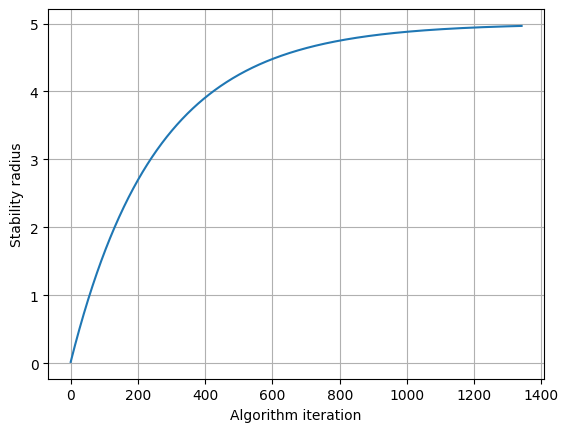

In [81]:
eigs = sindy_opt.PWeigs_history_
coef_history = sindy_opt.history_
rhos = []
for i in range(len(eigs)):
    if eigs[i][-1] < 0:
        # Q_this = np.tensordot(sindy_opt.PQ_, coef_history[i], axes=([4, 3], [1, 0]))
        # Q_this = Q_this.reshape(r, r * r)
        rhos.append(-eigs[i][-1] / (2 * eps_Q))
        # rhos.append(-eigs[i][-1] / (2 * np.linalg.norm(Q_this, 2)))
plt.plot(rhos[1:])
plt.grid(True)
plt.ylabel('Stability radius')
plt.xlabel('Algorithm iteration')
plt.show()

### Check for unbounded trajectories
So we have used inequality constraints to promote locally Lyapunov stable models, and obtained an estimate of the stability radius. Let's verify that trajectories within this radius are bounded, but trajectories outside this radius can be unstable.

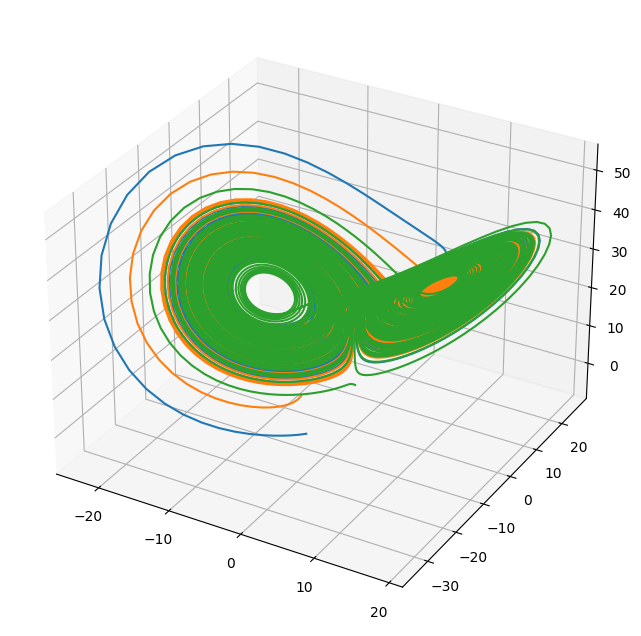

In [66]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
t_sim = t
for i in range(3):
    a0 = (np.random.rand(r) - 0.5) * 20  #* rhos[-1]
    x_traj = model.simulate(a0, t_sim)
    plt.plot(x_traj[:, 0], x_traj[:, 1], x_traj[:, -1])

We have relaxed the hard constraint slightly and solved the trapping SINDy objective function with inequality constraints dictating the amount of deviation allowed from perfect skew-symmetry in the quadratic coefficients:
$$ argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A)  \quad s.t. \quad -\epsilon_Q \leq Q_{ijk} + Q_{jik} + Q_{kji} \leq \epsilon_Q.$$ 
This allowed us to build locally Lyapunov stable models, and adjust the size of the local stability radius by varying $\epsilon_Q$. However, two other loss terms that can be used as alternatives to increase the size of the stability radius while avoiding extra constraints:
$$\alpha\|Q_{ijk}\|$$
and
$$\beta\|Q_{ijk} + Q_{jki} + Q_{kij}\|.$$
We can combine all of these options into the following unconstrained optimization problem:
$$argmin_{\mathbf{\xi},\mathbf m}\|\dot{\mathbf a} - \mathbf \Theta(\mathbf a) \mathbf{\xi}\|^2 + \gamma R(\mathbf \xi)  + \eta \lambda_1(\mathbf A) + \alpha\|Q_{ijk}\| + \beta\|Q_{ijk} + Q_{jki} + Q_{kij}\|.$$
We now solve this problem for $\alpha \gg \beta$, $\alpha \ll \beta$, and $\alpha \sim \beta \sim 1.$

In [52]:
max_iter = 10000
eta = 1.0e20
alpha = 1.0e-3
beta = 5e-3
threshold = 0
alpha_m = 1e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, np.eye(r), sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
print(np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1])))))

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 6.773e+03 ... 1.144e-18 ... 0.00e+00 ... 4.78e+02 ... 1.55e-01 ... 7.25e+03
 1000 ... 6.773e+03 ... 1.006e-23 ... 0.00e+00 ... 4.78e+02 ... 1.55e-01 ... 7.25e+03
 2000 ... 6.773e+03 ... 6.465e-27 ... 0.00e+00 ... 4.78e+02 ... 1.55e-01 ... 7.25e+03
(x0)' = -8.188 x0 + 8.754 x1 + -0.010 x2 + 0.006 x0x1 + -0.051 x0x2 + 0.035 x1x2 + -0.005 x0x0 + -0.002 x1x1
(x1)' = 27.574 x0 + -0.802 x1 + 0.002 x2 + -0.002 x0x1 + -0.988 x0x2 + -0.005 x1x2 + 0.001 x0x0 + 0.001 x1x1
(x2)' = -0.064 x0 + 0.041 x1 + -2.577 x2 + 0.964 x0x1 + 0.002 x0x2 + -0.001 x1x2 + 0.035 x0x0 + 0.007 x1x1 + -0.004 x2x2
optimal m:  [-1.23651218 -0.14099653 32.08628724]
As eigvals:  [-10.65160655  -2.84566876  -0.09927853]
Estimate of trapping region size, Rm =  882.0514542578326
Normalized trapping region size, Reff =  37.52797747108947
0.015230100065195248


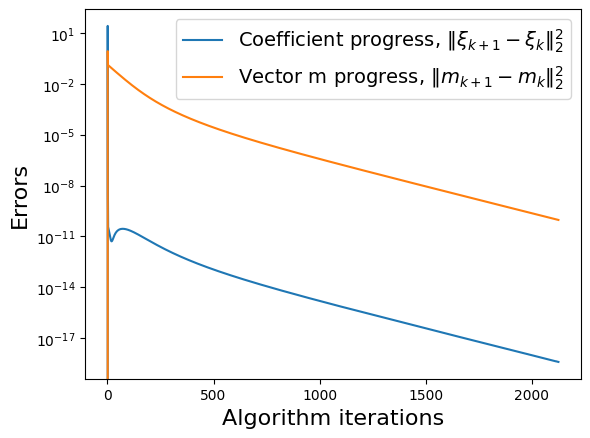

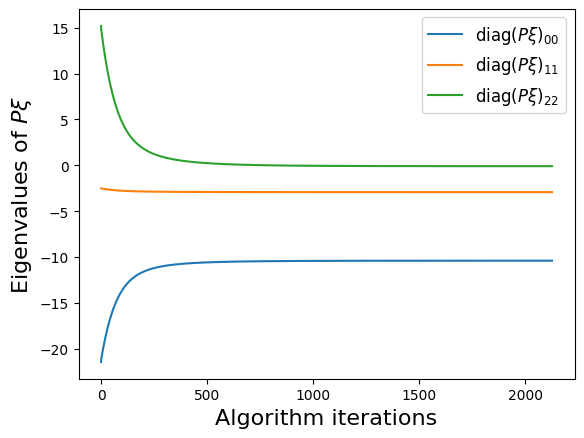

In [80]:
make_progress_plots(r, sindy_opt)